# Quantile Regression Forest using Zillow's `quantile-forest` library

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", message="X has feature names")

from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_pinball_loss
import scipy.stats as st
from quantile_forest import RandomForestQuantileRegressor

## DATA LOADING

In [2]:
df = pd.read_csv("data_loads_final.csv")
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])

test_start = pd.Timestamp("2010-12-09 23:00:00")
test_end   = pd.Timestamp("2011-12-09 23:00:00")
val_start  = pd.Timestamp("2009-12-09 23:00:00")

df_test  = df[(df["TIMESTAMP"] >= test_start) & (df["TIMESTAMP"] <= test_end)]
df_val   = df[(df["TIMESTAMP"] >= val_start)  & (df["TIMESTAMP"] <  test_start)]
df_train = df[df["TIMESTAMP"] < val_start]

# Features / target
excluded_cols = ['LOAD', 'TIMESTAMP', 'ZONEID', 'Task']
feature_cols  = [c for c in df.columns if c not in excluded_cols]

X_train, y_train = df_train[feature_cols], df_train['LOAD']
X_val,   y_val   = df_val[feature_cols],   df_val['LOAD']
X_test,  y_test  = df_test[feature_cols],  df_test['LOAD']



## Basic Model

Validation pinball loss (q=0.5): 5.4883
Coverage (q0.05–q0.95)              -> 0.9134
Interval width (q0.05–q0.95)        -> 47.7879
Coverage (q0.10–q0.90)              -> 0.8278
Interval width (q0.10–q0.90)        -> 36.9304
Coverage (q0.02–q0.98)              -> 0.9546
Interval width (q0.02–q0.98)        -> 60.0990
Pinball loss (q=0.02)               -> 1.2100
Pinball loss (q=0.05)               -> 1.9445
Pinball loss (q=0.10)               -> 2.8911
Pinball loss (q=0.50)               -> 5.5720
Pinball loss (q=0.90)               -> 2.5656
Pinball loss (q=0.95)               -> 1.5635
Pinball loss (q=0.98)               -> 0.7833


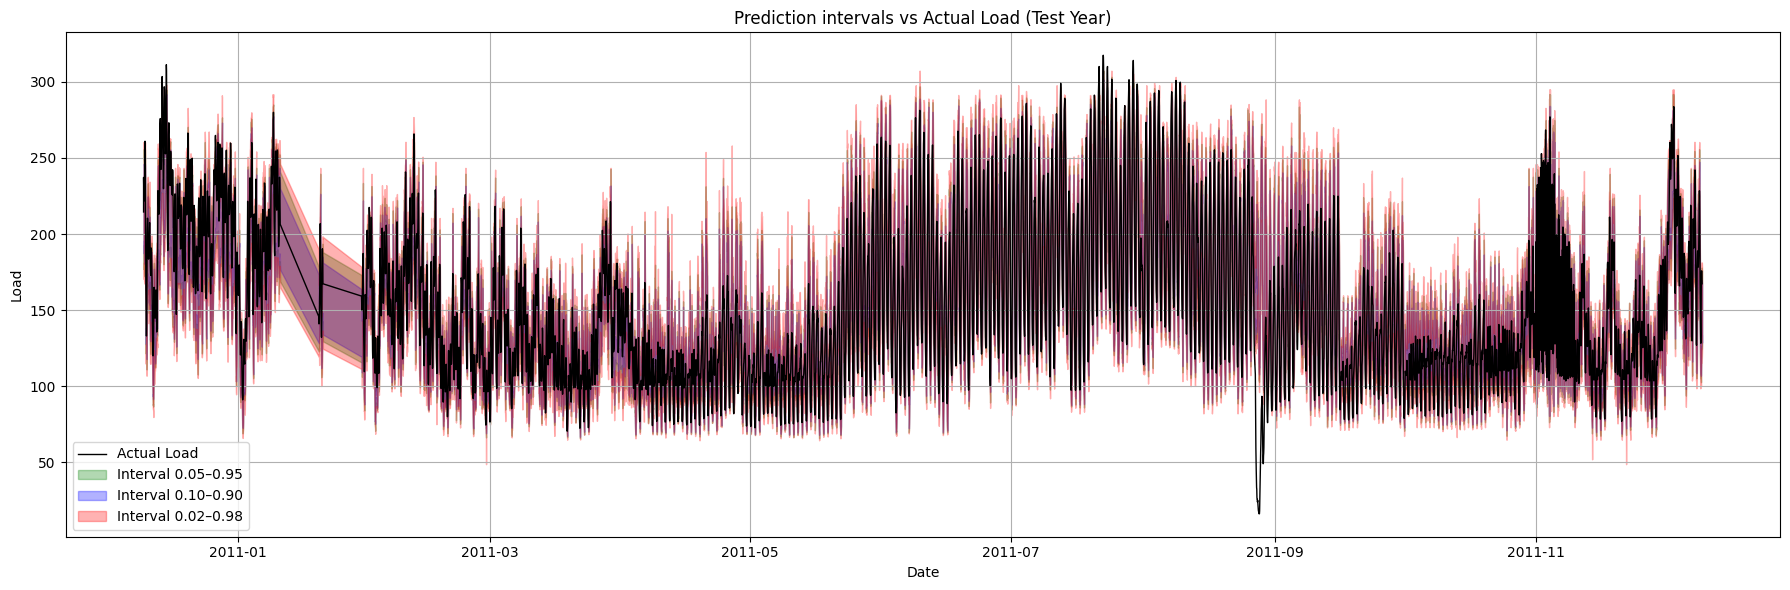

In [ ]:

# Fit model using cuantil 0.5 for tuning
model = RandomForestQuantileRegressor(n_estimators=200, min_samples_leaf=10, random_state=42)
model.fit(X_train.to_numpy(), y_train.to_numpy())

# Evaluate on validation set for tuning
val_preds = model.predict(X_val.to_numpy(), quantiles=[0.5])
val_loss = mean_pinball_loss(y_val, val_preds, alpha=0.5)
print(f"Validation pinball loss (q=0.5): {val_loss:.4f}")

# Final model with full quantile set
quantiles_used = [0.02, 0.05, 0.10, 0.50, 0.90, 0.95, 0.98]
model.fit(X_train.to_numpy(), y_train.to_numpy())
preds = model.predict(X_test.to_numpy(), quantiles=quantiles_used)

# Evaluate pinball loss for all quantiles
pinball_losses = {
    f'Pinball loss (q={q:.2f})': mean_pinball_loss(y_test, preds[:, i], alpha=q)
    for i, q in enumerate(quantiles_used)
}

# Interval metrics
quantile_pairs = [(0.05, 0.95), (0.10, 0.90), (0.02, 0.98)]
summary_dynamic = {}
for lower, upper in quantile_pairs:
    li = quantiles_used.index(lower)
    hi = quantiles_used.index(upper)
    lower_pred = preds[:, li]
    upper_pred = preds[:, hi]
    coverage = np.mean((y_test >= lower_pred) & (y_test <= upper_pred))
    width = np.mean(upper_pred - lower_pred)
    label = f"q{lower:.2f}–q{upper:.2f}"
    summary_dynamic[f"Coverage ({label})"] = coverage
    summary_dynamic[f"Interval width ({label})"] = width

# Final summary
summary = {**summary_dynamic, **pinball_losses}
for k, v in summary.items():
    print(f"{k:<35} -> {v:.4f}")

# Plot full test year
timestamps_test = df_test["TIMESTAMP"]
plt.figure(figsize=(18, 6))
plt.plot(timestamps_test, y_test, label="Actual Load", color="black", linewidth=1)

colors = ["green", "blue", "red"]
for (low, high), color in zip(quantile_pairs, colors):
    li = quantiles_used.index(low)
    hi = quantiles_used.index(high)
    plt.fill_between(timestamps_test,
                     preds[:, li],
                     preds[:, hi],
                     alpha=0.3,
                     label=f"Interval {low:.2f}–{high:.2f}",
                     color=color)

plt.title("Prediction intervals vs Actual Load (Test Year)")
plt.xlabel("Date")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Randomized Search (4 mins running)

In [ ]:
# Quantile Forest – Randomized HPO (median-tuned) + Final Refit



#  PredefinedSplit for RandomizedSearchCV (train=-1, val=0)
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
split_index = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold=split_index)

# Base estimator 
base = RandomForestQuantileRegressor(random_state=42)

# Randomized search space 
param_dist = {
    "n_estimators":     st.randint(50, 151),         
    "min_samples_leaf": st.randint(1, 51),          
    "max_depth":        [None, 10, 15, 20, 30, 40, 60, 80, 100, 120],
    "max_features":     ["sqrt", "log2", 0.3, 0.5, 0.7, 0.9],
}

# Scorer: negative pinball-loss @ median (q=0.5)
def neg_pinball_median(est, X, y):
    y_hat = est.predict(X, quantiles=[0.5])          # returns 1D for single quantile
    return -mean_pinball_loss(y, y_hat, alpha=0.5)

rs = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=60,                                       
    scoring=neg_pinball_median,
    cv=ps,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Run HPO on TRAIN vs VAL
rs.fit(X_trainval.to_numpy(), y_trainval.to_numpy())
print("Best params (median-tuned):", rs.best_params_)
print("Best validation pinball (q=0.5):", -rs.best_score_)



Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params (median-tuned): {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 77}
Best validation pinball (q=0.5): 5.336769406392695


In [ ]:
#  Final refit on TRAIN+VAL with MORE trees (first alternative)
best_params = rs.best_params_.copy()                 
best_params["n_estimators"] = 300                    # stronger final forest

final_model = RandomForestQuantileRegressor(
    random_state=42,
    **best_params
)
final_model.fit(X_trainval.to_numpy(), y_trainval.to_numpy())

#  Predict on TEST for all required quantiles
quantiles_full = [0.02, 0.05, 0.10, 0.50, 0.90, 0.95, 0.98]
preds = final_model.predict(X_test.to_numpy(), quantiles=quantiles_full)  # shape: (n_test, 7)

#  Metrics on TEST: pinball-loss per quantile
pinball_losses = {
    f"Pinball loss (q={q:.2f})": mean_pinball_loss(y_test, preds[:, i], alpha=q)
    for i, q in enumerate(quantiles_full)
}

In [22]:
# Coverage & width for key central intervals
quantile_pairs = [(0.05, 0.95), (0.10, 0.90), (0.02, 0.98)]
coverage_vals, width_vals, labels = [], [], []
for lo, hi in quantile_pairs:
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    low, up  = preds[:, li], preds[:, hi_i]
    coverage_vals.append(np.mean((y_test >= low) & (y_test <= up)))
    width_vals.append(np.mean(up - low))
    labels.append(f"{lo:.2f}–{hi:.2f}")

print("\n— TEST summary (single median-tuned model) —")
for k, v in pinball_losses.items():
    print(f"{k:<30} -> {v:8.4f}")
for lbl, c, w in zip(labels, coverage_vals, width_vals):
    print(f"Coverage ({lbl}): {c:8.4f} | Width ({lbl}): {w:8.4f}")


— TEST summary (single median-tuned model) —
Pinball loss (q=0.02)          ->   1.1880
Pinball loss (q=0.05)          ->   1.8704
Pinball loss (q=0.10)          ->   2.7366
Pinball loss (q=0.50)          ->   5.1977
Pinball loss (q=0.90)          ->   2.4339
Pinball loss (q=0.95)          ->   1.4827
Pinball loss (q=0.98)          ->   0.7379
Coverage (0.05–0.95):   0.9285 | Width (0.05–0.95):  47.2037
Coverage (0.10–0.90):   0.8449 | Width (0.10–0.90):  36.3102
Coverage (0.02–0.98):   0.9657 | Width (0.02–0.98):  59.6712


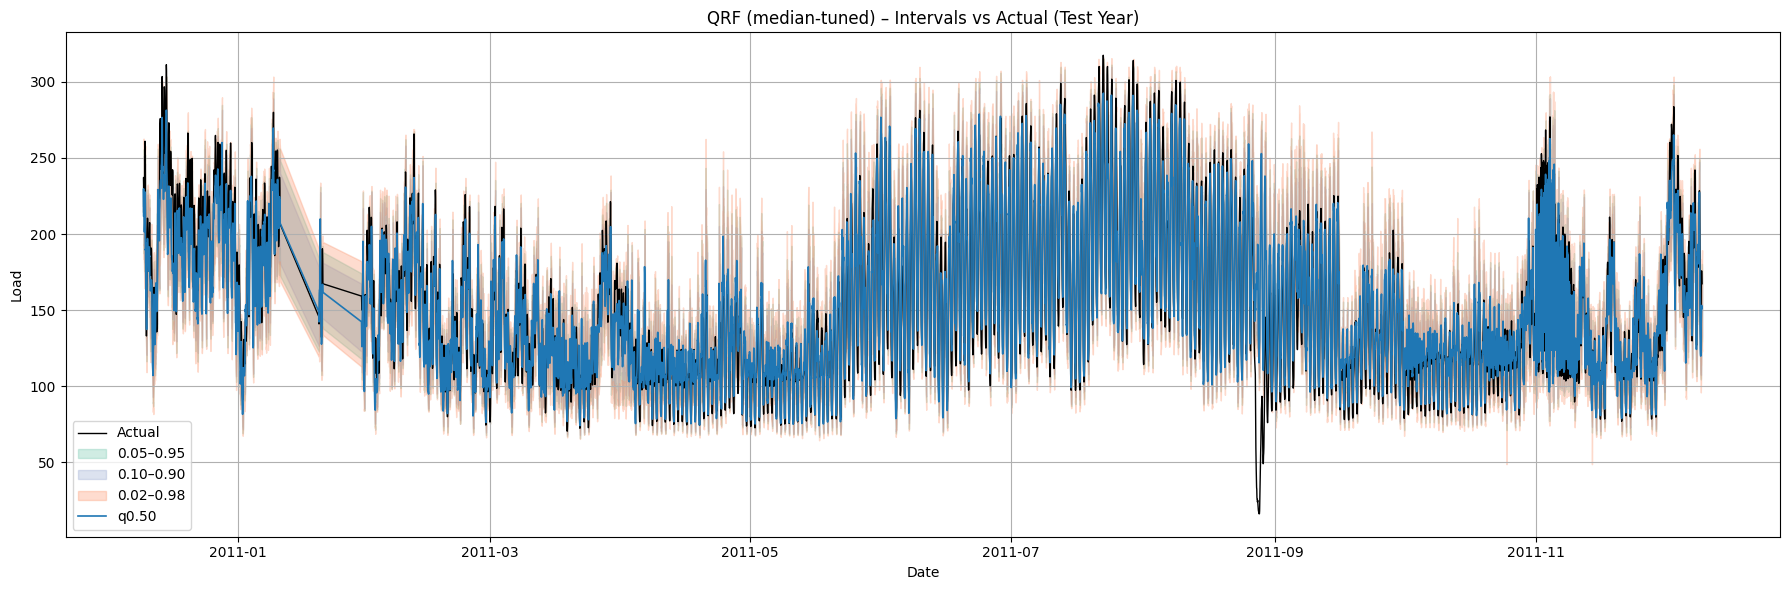

In [7]:
#  Visualization (full test year)
timestamps_test = df_test["TIMESTAMP"].to_numpy()
plt.figure(figsize=(18,6))
plt.plot(timestamps_test, y_test, color="black", lw=1, label="Actual")

colors = ["#66c2a5", "#8da0cb", "#fc8d62"]
for (lo, hi), c in zip(pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(timestamps_test, preds[:, li], preds[:, hi_i], color=c, alpha=0.30, label=f"{lo:.2f}–{hi:.2f}")

# median line
mid_idx = quantiles_full.index(0.50)
plt.plot(timestamps_test, preds[:, mid_idx], color="#1f77b4", lw=1.2, label="q0.50")

plt.title("QRF (median-tuned) – Intervals vs Actual (Test Year)")
plt.xlabel("Date"); plt.ylabel("Load")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

## Analysis

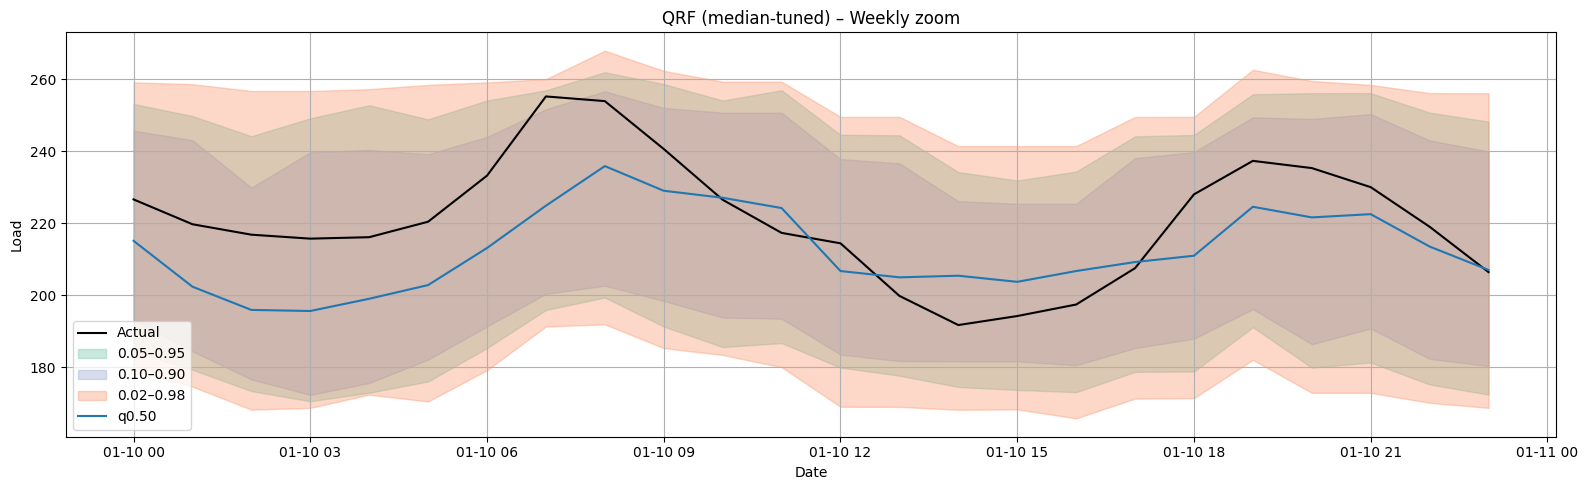

In [24]:
# Weekly zoom (choosing a week inside test window)
mask_week = (df_test["TIMESTAMP"] >= "2011-01-10") & (df_test["TIMESTAMP"] < "2011-01-17")
t_w = df_test.loc[mask_week, "TIMESTAMP"].to_numpy()
y_w = y_test.loc[mask_week].to_numpy()
pS_w = preds[mask_week.values, :]

plt.figure(figsize=(16,5))
plt.plot(t_w, y_w, color="black", lw=1.5, label="Actual")
for (lo, hi), c in zip(quantile_pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(t_w, pS_w[:, li], pS_w[:, hi_i], color=c, alpha=0.35, label=f"{lo:.2f}–{hi:.2f}")
plt.plot(t_w, pS_w[:, mid_idx], color="#1f77b4", lw=1.5, label="q0.50")
plt.title("QRF (median-tuned) – Weekly zoom")
plt.xlabel("Date"); plt.ylabel("Load"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()



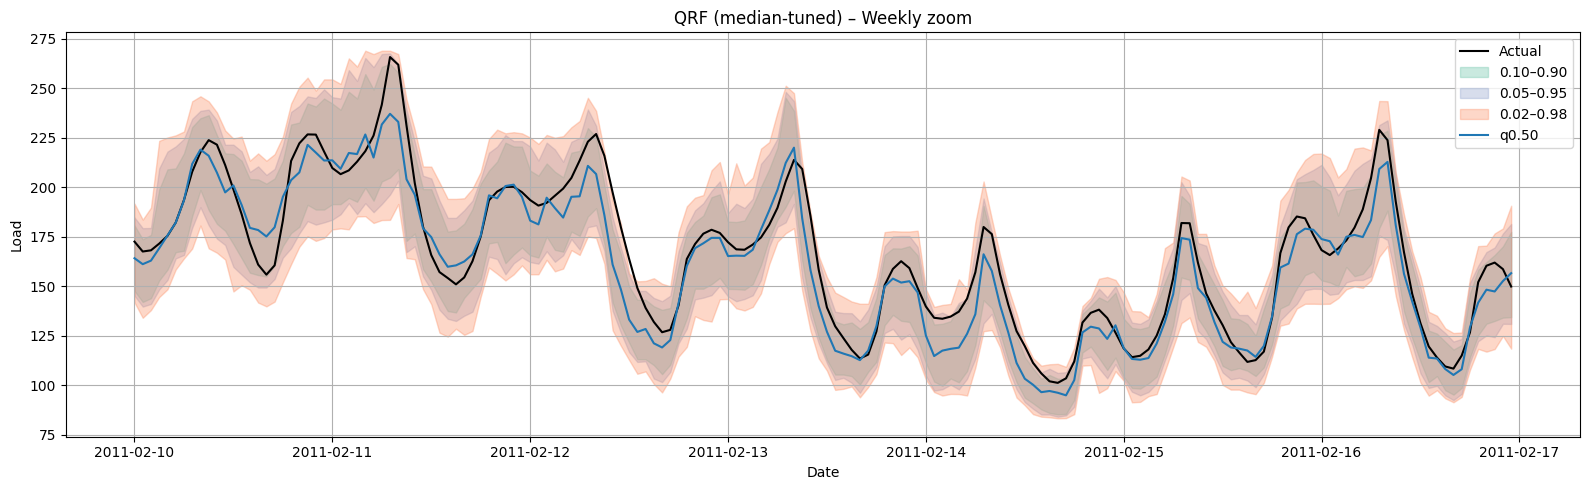

In [ ]:
mask_week = (df_test["TIMESTAMP"] >= "2011-02-10") & (df_test["TIMESTAMP"] < "2011-02-17")
t_w = df_test.loc[mask_week, "TIMESTAMP"].to_numpy()
y_w = y_test.loc[mask_week].to_numpy()
pS_w = preds[mask_week.values, :]

plt.figure(figsize=(16,5))
plt.plot(t_w, y_w, color="black", lw=1.5, label="Actual")
for (lo, hi), c in zip(quantile_pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(t_w, pS_w[:, li], pS_w[:, hi_i], color=c, alpha=0.35, label=f"{lo:.2f}–{hi:.2f}")
plt.plot(t_w, pS_w[:, mid_idx], color="#1f77b4", lw=1.5, label="q0.50")
plt.title("QRF (median-tuned) – Weekly zoom")
plt.xlabel("Date"); plt.ylabel("Load"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

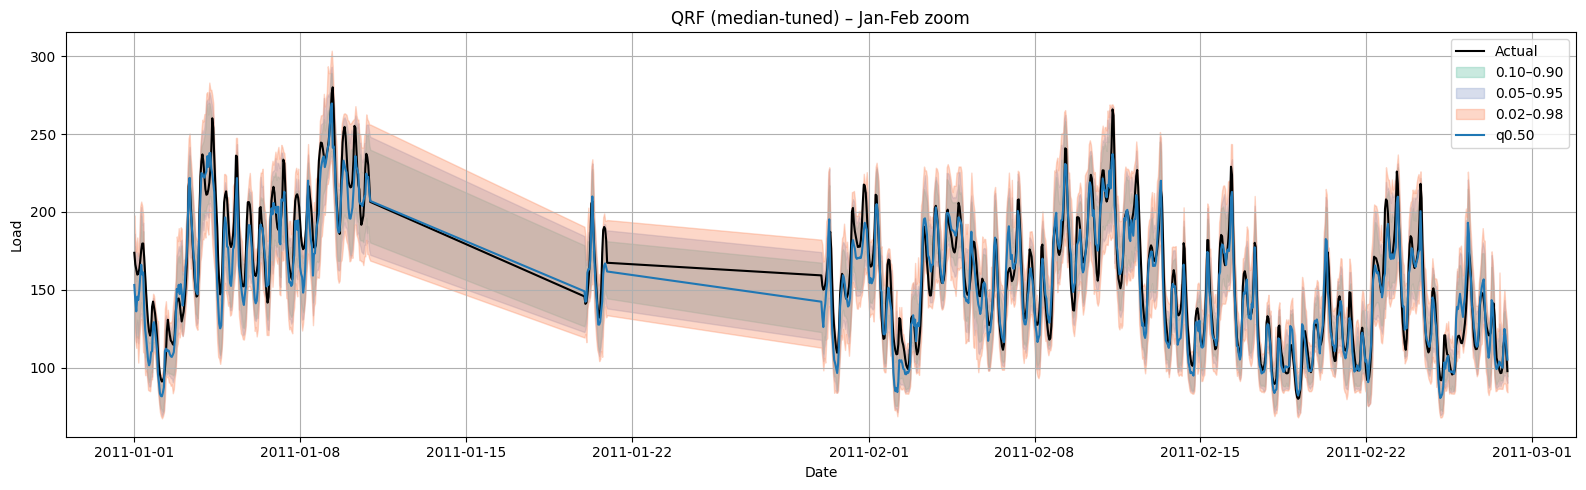

In [36]:
# 2 month zoom
mask_week = (df_test["TIMESTAMP"] >= "2011-01-01") & (df_test["TIMESTAMP"] < "2011-02-28")
t_w = df_test.loc[mask_week, "TIMESTAMP"].to_numpy()
y_w = y_test.loc[mask_week].to_numpy()
pS_w = preds[mask_week.values, :]

plt.figure(figsize=(16,5))
plt.plot(t_w, y_w, color="black", lw=1.5, label="Actual")
for (lo, hi), c in zip(quantile_pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(t_w, pS_w[:, li], pS_w[:, hi_i], color=c, alpha=0.35, label=f"{lo:.2f}–{hi:.2f}")
plt.plot(t_w, pS_w[:, mid_idx], color="#1f77b4", lw=1.5, label="q0.50")
plt.title("QRF (median-tuned) – Jan-Feb zoom")
plt.xlabel("Date"); plt.ylabel("Load"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

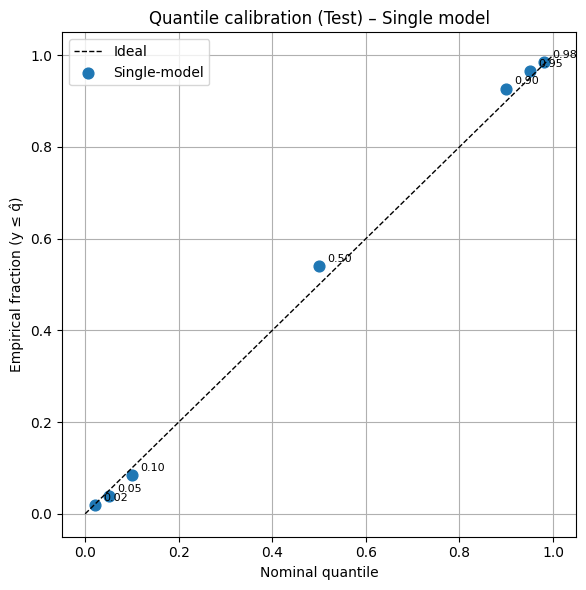

In [25]:
# Calibration scatter (empirical vs nominal)
empirical = [np.mean(y_test <= preds[:, i]) for i,_ in enumerate(quantiles_full)]
nominal = np.array(quantiles_full)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'k--',lw=1,label="Ideal")
plt.scatter(nominal, empirical, s=60, label="Single-model")
for q, e in zip(nominal, empirical):
    plt.annotate(f"{q:.2f}", (q, e), textcoords="offset points", xytext=(6,3), fontsize=8)
plt.title("Quantile calibration (Test) – Single model")
plt.xlabel("Nominal quantile"); plt.ylabel("Empirical fraction (y ≤ q̂)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()



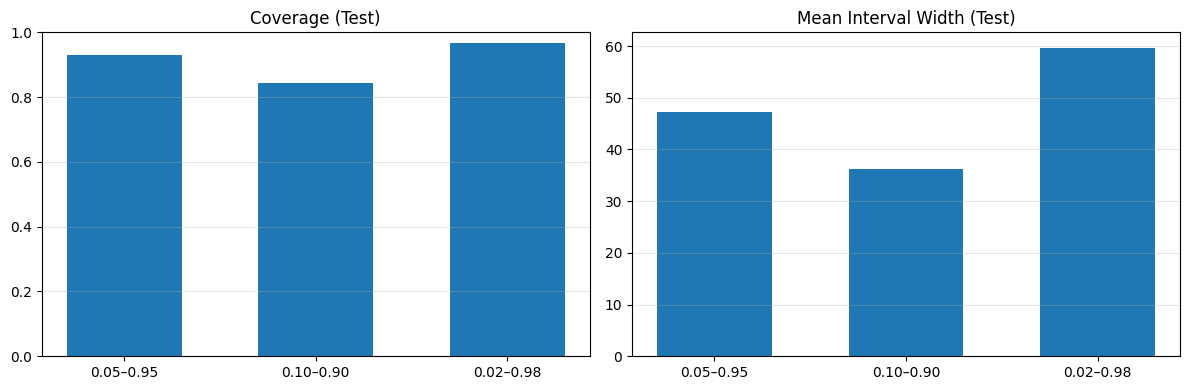

In [26]:
# Coverage & Width bars
x = np.arange(len(labels)); w = 0.6
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(x, coverage_vals, width=w)
axes[0].set_ylim(0,1); axes[0].set_title("Coverage (Test)")
axes[0].set_xticks(x); axes[0].set_xticklabels(labels); axes[0].grid(axis="y", alpha=.3)

axes[1].bar(x, width_vals, width=w)
axes[1].set_title("Mean Interval Width (Test)")
axes[1].set_xticks(x); axes[1].set_xticklabels(labels); axes[1].grid(axis="y", alpha=.3)
plt.tight_layout(); plt.show()

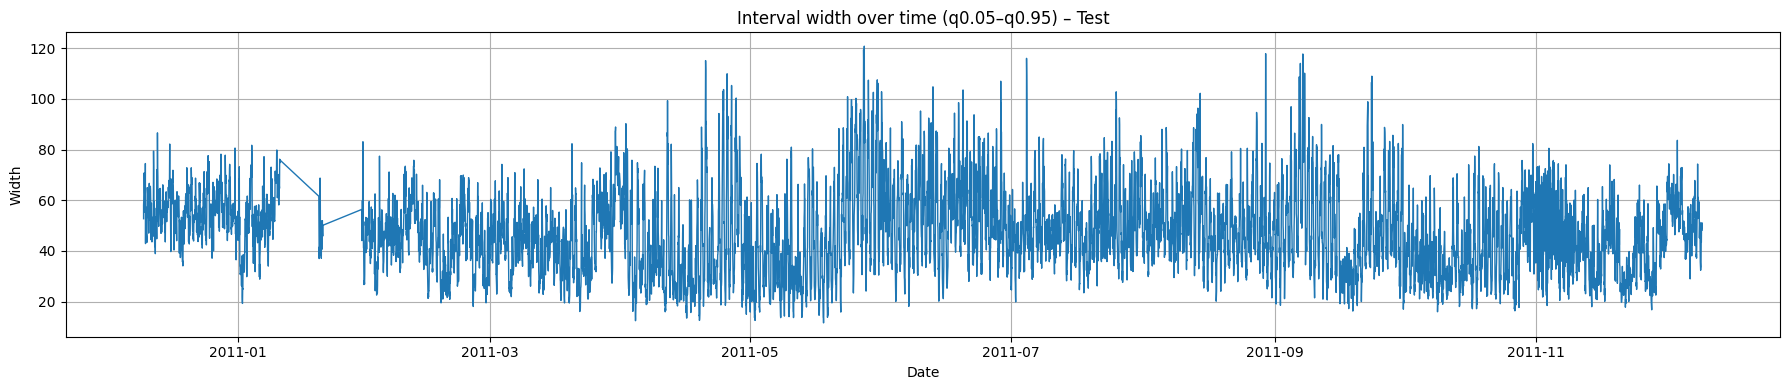

In [ ]:
# Interval width over time (0.05–0.95 case)
lo, hi = 0.05, 0.95
li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
width_series = preds[:, hi_i] - preds[:, li]

plt.figure(figsize=(18,4))
plt.plot(timestamps_test, width_series, lw=1)
plt.title(f"Interval width over time (q{lo:.2f}–q{hi:.2f}) – Test")
plt.xlabel("Date"); plt.ylabel("Width")
plt.grid(True); plt.tight_layout(); plt.show()

## Alternative path — Per-quantile tuning (independent HPO for each quantile)

#### WARNING! 45 mins running

In [9]:
import scipy.stats as st

# PredefinedSplit (same as above)
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
ps = PredefinedSplit(test_fold=[-1]*len(X_train) + [0]*len(X_val))

# Quantiles to tune independently
quantiles_full = [0.02, 0.05, 0.10, 0.50, 0.90, 0.95, 0.98]

# Shared search space
param_dist = {
    "n_estimators":     st.randint(40, 151),          
    "min_samples_leaf": st.randint(1, 51),
    "max_depth":        [None, 10, 15, 20, 30, 40, 60, 80, 100, 120],
    "max_features":     ["sqrt", "log2", 0.3, 0.5, 0.7, 0.9],
}

def make_neg_pinball(q):
    def scorer(est, X, y):
        y_hat = est.predict(X, quantiles=[q])         # 1D
        return -mean_pinball_loss(y, y_hat, alpha=q)
    return scorer

best_params_per_q = {}
models_per_q = {}
preds_per_q = []

for q in quantiles_full:
    base = RandomForestQuantileRegressor(random_state=42)
    rs_q = RandomizedSearchCV(
        estimator=base,
        param_distributions=param_dist,
        n_iter=60,
        scoring=make_neg_pinball(q),
        cv=ps,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    rs_q.fit(X_trainval.to_numpy(), y_trainval.to_numpy())
    print(f"Best params for q={q:.2f}:", rs_q.best_params_)

    # Refit with larger forest
    best_params_q = rs_q.best_params_.copy()
    best_params_q["n_estimators"] = 300
    model_q = RandomForestQuantileRegressor(random_state=42, **best_params_q)
    model_q.fit(X_trainval.to_numpy(), y_trainval.to_numpy())

    pred_q = model_q.predict(X_test.to_numpy(), quantiles=[q])  # 1D
    preds_per_q.append(pred_q.reshape(-1, 1))

# Stack into (n_samples, n_quantiles) aligned with quantiles_full order
preds_qwise = np.hstack(preds_per_q)



Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.02: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 67}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.05: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 67}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.10: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 67}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.50: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 67}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.90: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimators': 67}
Fitting 1 folds for each of 60 candidates, totalling 60 fits
Best params for q=0.95: {'max_depth': 120, 'max_features': 0.7, 'min_samples_leaf': 6, 'n_estimator

In [ ]:
# Metrics on TEST
pinball_losses_qwise = {
    f"Pinball loss (q={q:.2f})": mean_pinball_loss(y_test, preds_qwise[:, i], alpha=q)
    for i, q in enumerate(quantiles_full)
}

# Coverage & width for key central intervals
quantile_pairs = [(0.05, 0.95), (0.10, 0.90), (0.02, 0.98)]
coverage_vals, width_vals, labels = [], [], []
for lo, hi in quantile_pairs:
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    low, up  = preds_qwise[:, li], preds_qwise[:, hi_i]
    coverage_vals.append(np.mean((y_test >= low) & (y_test <= up)))
    width_vals.append(np.mean(up - low))
    labels.append(f"{lo:.2f}–{hi:.2f}")

print("\n— TEST summary (per-quantile tuned models) —")
for k, v in pinball_losses_qwise.items():
    print(f"{k:<30} -> {v:8.4f}")
for lbl, c, w in zip(labels, coverage_vals, width_vals):
    print(f"Coverage ({lbl}): {c:8.4f} | Width ({lbl}): {w:8.4f}")


— TEST summary (per-quantile tuned models) —
Pinball loss (q=0.02)          ->   1.1880
Pinball loss (q=0.05)          ->   1.8704
Pinball loss (q=0.10)          ->   2.7366
Pinball loss (q=0.50)          ->   5.1977
Pinball loss (q=0.90)          ->   2.4339
Pinball loss (q=0.95)          ->   1.4827
Pinball loss (q=0.98)          ->   0.7379
Coverage (0.05–0.95):   0.9285 | Width (0.05–0.95):  47.2037
Coverage (0.10–0.90):   0.8449 | Width (0.10–0.90):  36.3102
Coverage (0.02–0.98):   0.9657 | Width (0.02–0.98):  59.6712


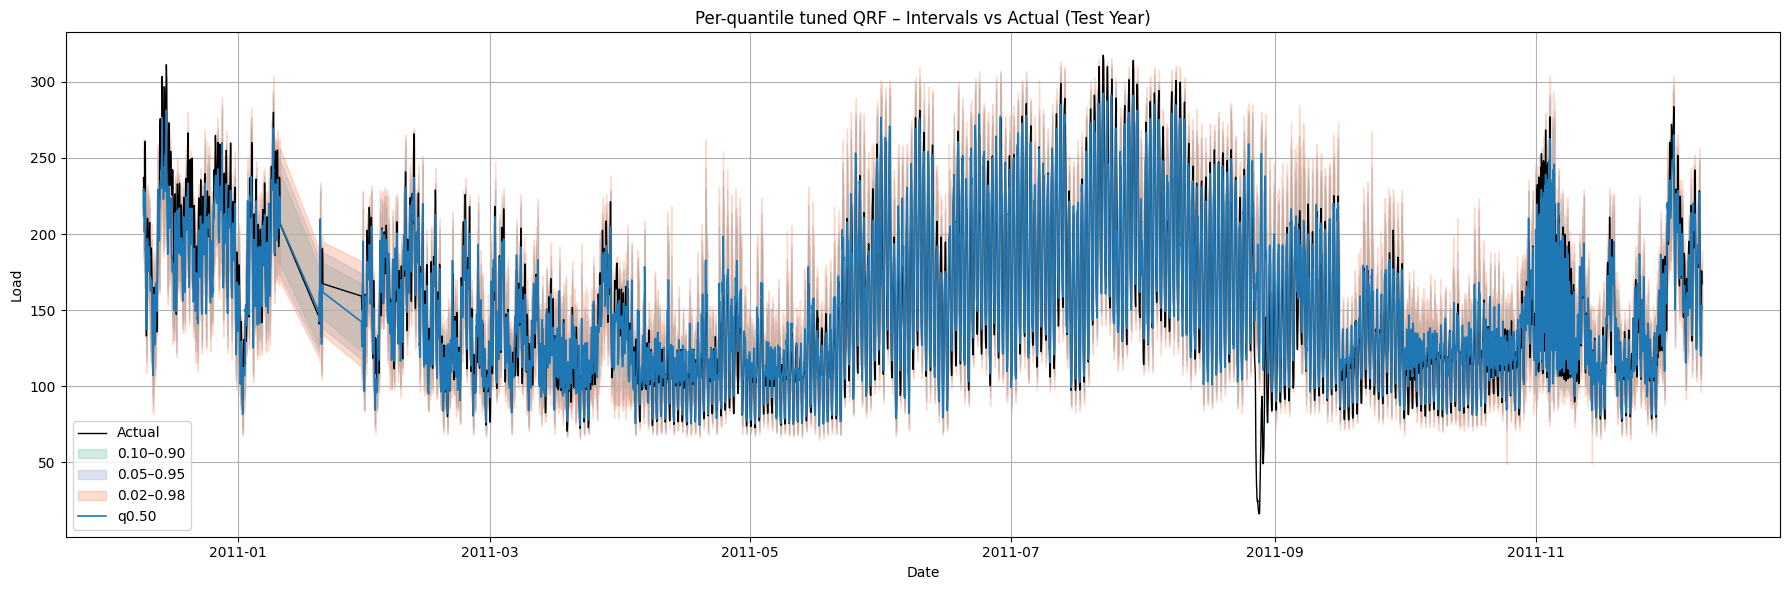

In [ ]:
timestamps_test = df_test["TIMESTAMP"].to_numpy()
y_true = np.asarray(y_test)

# Intervals to plot
quantile_pairs = [(0.10, 0.90), (0.05, 0.95), (0.02, 0.98)]
colors = ["#66c2a5", "#8da0cb", "#fc8d62"]  # green, purple, orange (pastel)

plt.figure(figsize=(18, 6))
plt.plot(timestamps_test, y_true, color="black", lw=1, label="Actual")

for (lo, hi), c in zip(quantile_pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(timestamps_test,
                     preds_qwise[:, li],
                     preds_qwise[:, hi_i],
                     color=c, alpha=0.30, label=f"{lo:.2f}–{hi:.2f}")

# Add the median line
mid_idx = quantiles_full.index(0.50)
plt.plot(timestamps_test, preds_qwise[:, mid_idx], color="#1f77b4", lw=1.2, label="q0.50")

plt.title("Per-quantile tuned QRF – Intervals vs Actual (Test Year)")
plt.xlabel("Date"); plt.ylabel("Load")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

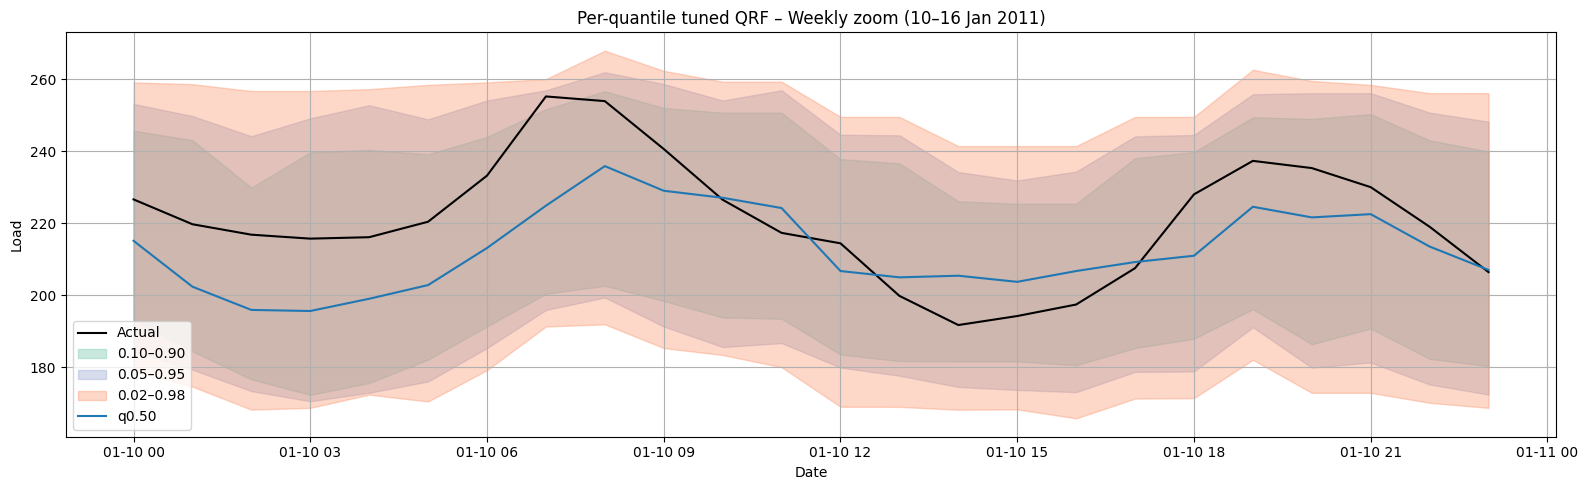

In [14]:
mask_week = (df_test["TIMESTAMP"] >= "2011-01-10") & (df_test["TIMESTAMP"] < "2011-01-17")

t_w = df_test.loc[mask_week, "TIMESTAMP"].to_numpy()
y_w = y_test.loc[mask_week].to_numpy()
preds_w = preds_qwise[mask_week.values, :]

plt.figure(figsize=(16, 5))
plt.plot(t_w, y_w, color="black", lw=1.5, label="Actual")

for (lo, hi), c in zip(quantile_pairs, colors):
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    plt.fill_between(t_w, preds_w[:, li], preds_w[:, hi_i], color=c, alpha=0.35, label=f"{lo:.2f}–{hi:.2f}")

mid_idx = quantiles_full.index(0.50)
plt.plot(t_w, preds_w[:, mid_idx], color="#1f77b4", lw=1.5, label="q0.50")

plt.title("Per-quantile tuned QRF – Weekly zoom (10–16 Jan 2011)")
plt.xlabel("Date"); plt.ylabel("Load")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

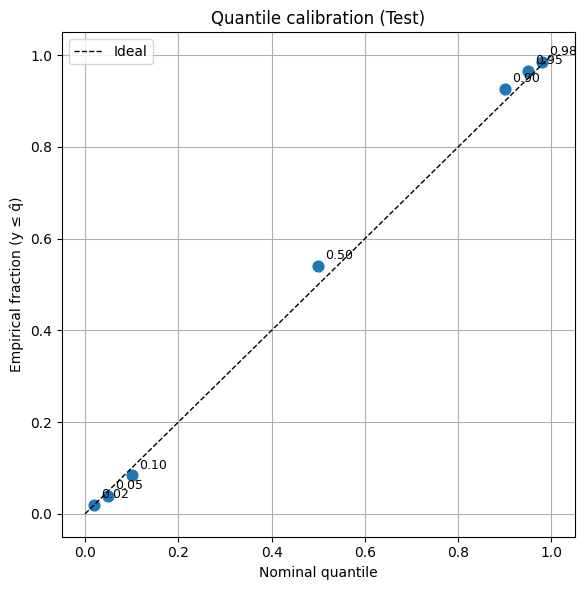

In [15]:
# Empirical coverage at each quantile
empirical = [np.mean(y_true <= preds_qwise[:, i]) for i, q in enumerate(quantiles_full)]
nominal = np.array(quantiles_full)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], 'k--', lw=1, label="Ideal")    # y = x
plt.scatter(nominal, empirical, s=60)
for q, e in zip(nominal, empirical):
    plt.annotate(f"{q:.2f}", (q, e), textcoords="offset points", xytext=(5,5), fontsize=9)

plt.title("Quantile calibration (Test)")
plt.xlabel("Nominal quantile"); plt.ylabel("Empirical fraction (y ≤ q̂)")
plt.grid(True); plt.tight_layout(); plt.legend()
plt.show()

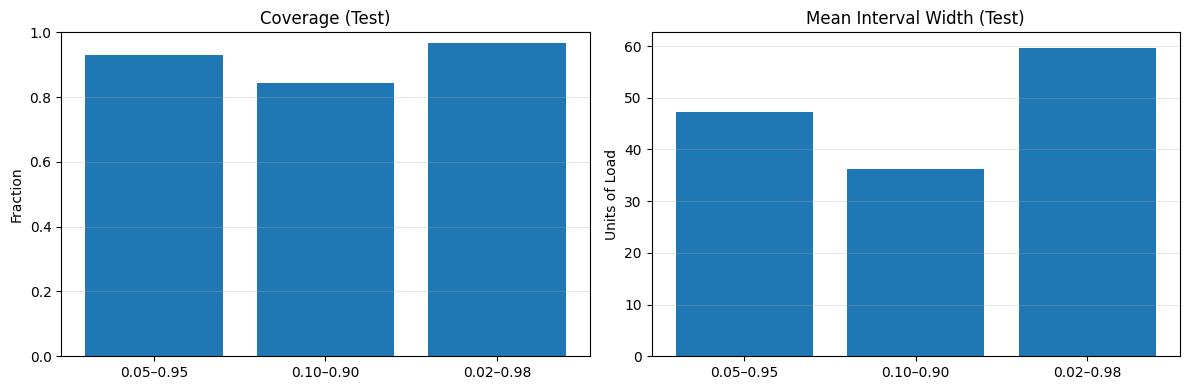

In [16]:
pairs = [(0.05, 0.95), (0.10, 0.90), (0.02, 0.98)]
labels = [f"{lo:.2f}–{hi:.2f}" for lo,hi in pairs]

coverage_vals = []
width_vals = []
for lo, hi in pairs:
    li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
    low, up = preds_qwise[:, li], preds_qwise[:, hi_i]
    coverage_vals.append(np.mean((y_true >= low) & (y_true <= up)))
    width_vals.append(np.mean(up - low))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axes[0].bar(labels, coverage_vals)
axes[0].set_ylim(0,1)
axes[0].set_title("Coverage (Test)"); axes[0].set_ylabel("Fraction"); axes[0].grid(True, axis="y", alpha=.3)

axes[1].bar(labels, width_vals)
axes[1].set_title("Mean Interval Width (Test)"); axes[1].set_ylabel("Units of Load"); axes[1].grid(True, axis="y", alpha=.3)

plt.tight_layout(); plt.show()


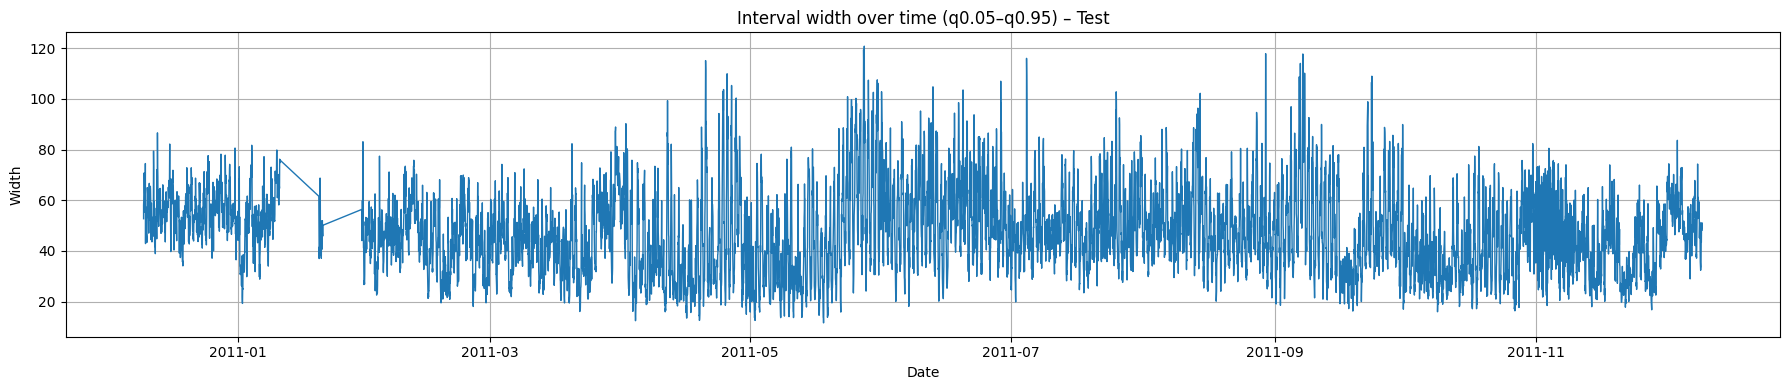

In [ ]:
lo, hi = 0.05, 0.95  
li, hi_i = quantiles_full.index(lo), quantiles_full.index(hi)
width_series = preds_qwise[:, hi_i] - preds_qwise[:, li]

plt.figure(figsize=(18,4))
plt.plot(timestamps_test, width_series, lw=1)
plt.title(f"Interval width over time (q{lo:.2f}–q{hi:.2f}) – Test")
plt.xlabel("Date"); plt.ylabel("Width")
plt.grid(True); plt.tight_layout(); plt.show()